In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

# Loading the datasets
customers_df = pd.read_csv("/content/Customers.csv")
products_df = pd.read_csv("/content/Products.csv")
transactions_df = pd.read_csv("/content/Transactions.csv")

# Displaying head and info to inspect the datasets
print("Customers DataFrame:")
print(customers_df.head())
print(customers_df.info())

print("\nProducts DataFrame:")
print(products_df.head())
print(products_df.info())

print("\nTransactions DataFrame:")
print(transactions_df.head())
print(transactions_df.info())

Customers DataFrame:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products DataFrame:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiv

In [2]:
# Converting date columns to datetime objects
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [3]:
    # Merging all DataFrames
    transactions_merged_df = pd.merge(transactions_df, products_df, on = "ProductID")
    transactions_merged_df = pd.merge(transactions_merged_df, customers_df, on = "CustomerID")

    # Aggregating features
    customer_features = transactions_merged_df.groupby('CustomerID').agg(
        num_transactions=('TransactionID', 'count'),
        total_spending=('TotalValue', 'sum'),
         purchase_frequency = ('TransactionDate', lambda x: len(x) / (x.max() - x.min()).days if (x.max() - x.min()).days > 0 else 0),
        avg_transaction_value=('TotalValue', 'mean'),
        fav_product_category =('Category', lambda x: x.value_counts().index[0])
    ).reset_index()

    # Adding region
    customer_region_df = transactions_merged_df.groupby('CustomerID')['Region'].apply(lambda x: x.mode()[0]).reset_index()
    customer_features = pd.merge(customer_features,customer_region_df, on="CustomerID")

    # One-Hot encoding categorical columns
    customer_features = pd.get_dummies(customer_features, columns = ['fav_product_category', 'Region'])

    # Feature Scaling
    customer_features_scaled = StandardScaler().fit_transform(customer_features.drop('CustomerID', axis = 1))
    customer_features_scaled_df = pd.DataFrame(customer_features_scaled, columns=customer_features.drop('CustomerID', axis = 1).columns)

In [4]:
    db_index = {}
    for k in range(2,11):
        kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
        kmeans.fit(customer_features_scaled_df)
        labels = kmeans.labels_
        db = davies_bouldin_score(customer_features_scaled_df,labels)
        db_index[k] = db

    best_k = min(db_index, key=db_index.get) # Get the K value that gives the minimum DB index
    print("Best number of clusters", best_k)
    print(db_index)
    print("Best DB Index",min(db_index.values()))

    kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
    kmeans.fit(customer_features_scaled_df)
    labels = kmeans.labels_

    customer_features['cluster'] = labels

Best number of clusters 10
{2: 2.6687578655521436, 3: 2.0174200293779503, 4: 1.6307328450727585, 5: 1.6629210658042695, 6: 1.303367196635896, 7: 1.2722034057987859, 8: 1.2731788228398502, 9: 1.2365767806165324, 10: 1.220390165569878}
Best DB Index 1.220390165569878


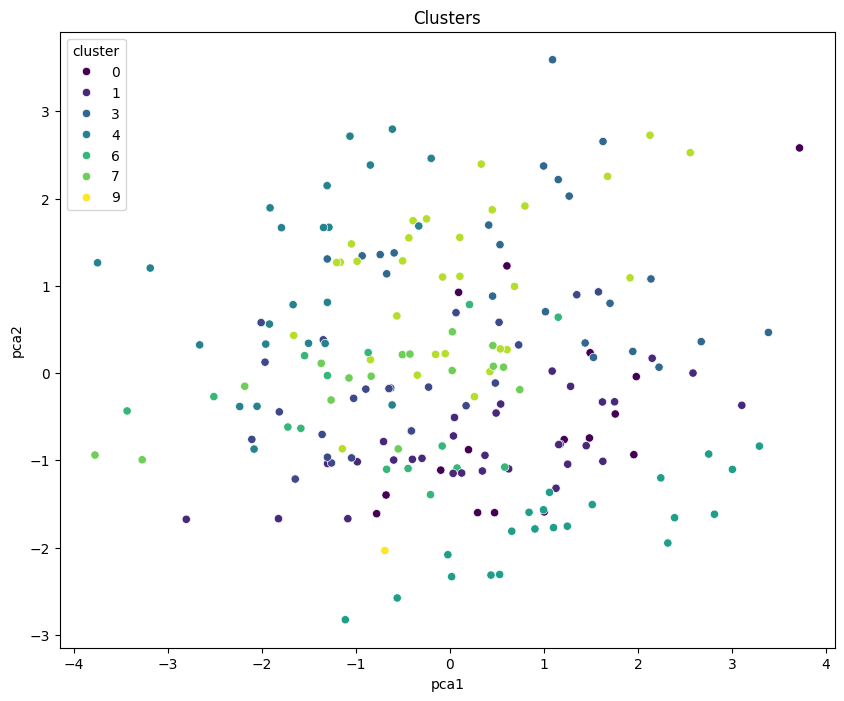

In [5]:
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(customer_features_scaled_df)
    pca_df = pd.DataFrame(data = pca_features, columns = ['pca1','pca2'])
    pca_df['cluster'] = labels

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df, palette="viridis")
    plt.title("Clusters")
    plt.show()

In [6]:
     print(f"Best Number of Clusters: {best_k}")
     print(f"DB Index: {min(db_index.values())}")

Best Number of Clusters: 10
DB Index: 1.220390165569878
